In [58]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sb
color = sb.color_palette()
sb.set_style('darkgrid')

#ignore warnings from sklearn
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

from scipy import stats
from scipy.stats import norm, skew

In [59]:
#reading data provided from kaggle
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [60]:
print(train.shape)
test.shape

(1460, 81)


(1459, 80)

In [184]:
#storing ID
train_ID = train['Id']
test_ID = test['Id']

#dropping ID from main df since it should not be used with regression
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [ ]:
test_ID

In [185]:
print(train.shape)
test.shape

(1460, 80)


(1459, 79)

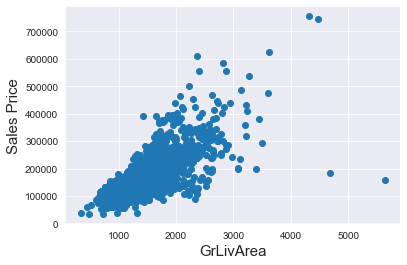

In [186]:
#plot of GrLivArea vs SalePrice
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('Sales Price', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

There are two outliers with high GrLivArea (Above ground living area square feet) and low Sale Price. Going to remove them.

In [187]:
#deleting
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index) 

In [188]:
print(train.shape)

(1458, 80)


skew is 1.8812964895244009


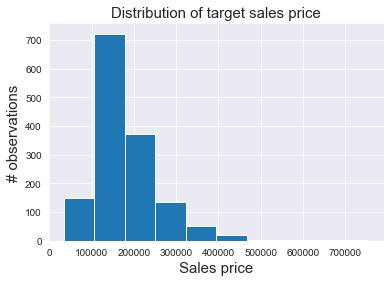

In [189]:
#original sales price distribution
print('skew is', train.SalePrice.skew())   
plt.hist(train['SalePrice'])
plt.title('Distribution of target sales price', fontsize = 15)
plt.ylabel('# observations', fontsize = 15)
plt.xlabel('Sales price', fontsize = 15)
plt.show()

The target variable Sales Price is not normal and is right skewed. We will try to make it a more normal with a log transform.

In [190]:
#numpy fuction log1p which  applies log(1+x) to sales price
train["SalePrice"] = np.log1p(train["SalePrice"])

skew is 0.12157976050304882


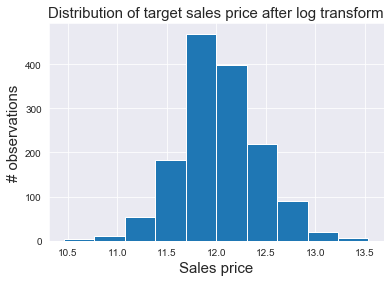

In [191]:
#original sales price distribution
print('skew is', train.SalePrice.skew())   
plt.hist(train['SalePrice'])
plt.title('Distribution of target sales price after log transform', fontsize = 15)
plt.ylabel('# observations', fontsize = 15)
plt.xlabel('Sales price', fontsize = 15)
plt.show()

Distribution is more normal now.

In [192]:
sizetrain = train.shape[0] # #storing number of observation for train since we are concatenating them
sizetest = test.shape[0] #storing number of observation for test
y_train = train.SalePrice.values #target variable stored from train set
concat_data = pd.concat((train, test)).reset_index(drop=True) #concatenating both train and test
sizetest

1459

In [193]:
concat_data.shape

(2917, 80)

In [194]:
concat_data.drop(['SalePrice'], axis=1, inplace=True) #removing sale price from concat-ed df (still stored in y_train)
concat_data.shape

(2917, 79)

Text(0.5, 1.0, 'Percent missing per feature')

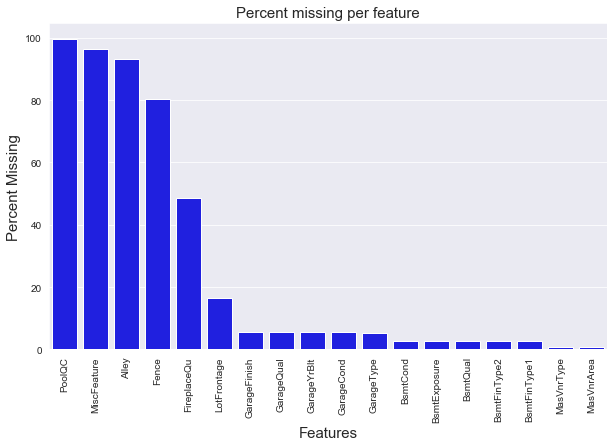

In [195]:
na_concat_data = (concat_data.isnull().sum() / len(concat_data)) * 100
na_concat_data = na_concat_data.sort_values(ascending=False)[:18] # % missing for each feature in concatenated data


fig, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sb.barplot(x=na_concat_data.index, y=na_concat_data, color='blue')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent Missing', fontsize=15)
plt.title('Percent missing per feature', fontsize=15)

Handling Missing Values

In [196]:
concat_data["PoolQC"] = concat_data["PoolQC"].fillna("None") #NA in this feature means no pool, so filling with "none"
concat_data["MiscFeature"] = concat_data["MiscFeature"].fillna("None") #NA means no feature
concat_data["Alley"] = concat_data["Alley"].fillna("None") #NA means no alley access
concat_data["Fence"] = concat_data["Fence"].fillna("None") #NA means no fence
concat_data["FireplaceQu"] = concat_data["FireplaceQu"].fillna("None") #NA means no fireplace

In [197]:
#for this feature, we assume that those belonging to same neighborhoods will have similar values, filling with median
concat_data["LotFrontage"] = concat_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [198]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    concat_data[col] = concat_data[col].fillna('None')

In [199]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    concat_data[col] = concat_data[col].fillna(0)

In [200]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    concat_data[col] = concat_data[col].fillna(0)

In [201]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    concat_data[col] = concat_data[col].fillna('None')

In [202]:
concat_data["MasVnrType"] = concat_data["MasVnrType"].fillna("None")
concat_data["MasVnrArea"] = concat_data["MasVnrArea"].fillna(0)

In [203]:
#RL is frequently occuring for this feature, so mode = 'RL' for this replacement
concat_data['MSZoning'] = concat_data['MSZoning'].fillna(concat_data['MSZoning'].mode()[0])

In [204]:
concat_data = concat_data.drop(['Utilities'], axis=1) #only 3 observations are not "AllPub, so deleting"

In [205]:
concat_data["Functional"] = concat_data["Functional"].fillna("Typ") #Says assume Typ, so NA replaced with Typ

In [206]:
concat_data['Electrical'] = concat_data['Electrical'].fillna(concat_data['Electrical'].mode()[0])

In [207]:
concat_data['KitchenQual'] = concat_data['KitchenQual'].fillna(concat_data['KitchenQual'].mode()[0])

In [208]:
concat_data['Exterior1st'] = concat_data['Exterior1st'].fillna(concat_data['Exterior1st'].mode()[0])
concat_data['Exterior2nd'] = concat_data['Exterior2nd'].fillna(concat_data['Exterior2nd'].mode()[0])

In [209]:
concat_data['SaleType'] = concat_data['SaleType'].fillna(concat_data['SaleType'].mode()[0])

In [210]:
concat_data['MSSubClass'] = concat_data['MSSubClass'].fillna("None")

In [211]:
#Check if there are remaining missing values
na_concat_data = (concat_data.isnull().sum() / len(concat_data)) * 100
na_concat_data = na_concat_data.sort_values(ascending=False)[:18] # % missing for each feature in concatenated data
na_concat_data

YrSold          0.0
Foundation      0.0
ExterCond       0.0
ExterQual       0.0
Exterior1st     0.0
Exterior2nd     0.0
Fence           0.0
FireplaceQu     0.0
Fireplaces      0.0
FullBath        0.0
Electrical      0.0
Functional      0.0
GarageArea      0.0
GarageCars      0.0
GarageCond      0.0
GarageFinish    0.0
GarageQual      0.0
GarageType      0.0
dtype: float64

In [212]:
#The building class is actually categorical not numerical so converting to str
concat_data['MSSubClass'] = concat_data['MSSubClass'].apply(str)

#The condition is actually categorical not numerical so converting to str
concat_data['OverallCond'] = concat_data['OverallCond'].astype(str)

#Year and month sold are categorical
concat_data['YrSold'] = concat_data['YrSold'].astype(str)
concat_data['MoSold'] = concat_data['MoSold'].astype(str)

In [213]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
#LabelEncoder to categorical features, needed for regression later
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(concat_data[c].values)) 
    concat_data[c] = lbl.transform(list(concat_data[c].values))

concat_data.shape

(2917, 78)

In [214]:
#adding a feature that takes the total square footage from basement, 1st floor, and second floor
concat_data['TotalSF'] = concat_data['TotalBsmtSF'] + concat_data['1stFlrSF'] + concat_data['2ndFlrSF']
concat_data.shape

(2917, 79)

Since we would like normal distributions for the independent variables, we are checking skewness

In [215]:
numeric_feats = concat_data.dtypes[concat_data.dtypes != "object"].index
skewed_feats = concat_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [216]:
#using box cox transform for features with skewness over 0.75
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    
    concat_data[feat] = boxcox1p(concat_data[feat], lam)
    

There are 59 skewed numerical features to Box Cox transform


In [218]:
#dummifying categorical features
concat_data = pd.get_dummies(concat_data)
print(concat_data.shape)

(2917, 220)


In [219]:
from sklearn.model_selection import train_test_split

x_train = concat_data[:sizetrain]
x_test = concat_data[sizetrain:]

xtrain, xtest, ytrain, ytest = train_test_split(x_train, y_train, test_size=0.20, random_state=7)

print(xtrain.shape)
print(xtest.shape)

(1166, 220)
(292, 220)


In [220]:
y=pd.DataFrame()
y['SalePrice']=y_train
x_train.to_csv('x_train.csv',index=False)
x_test.to_csv('x_test.csv',index=False)
y.to_csv('y_train.csv',index=False)

Regression Modelling

In [6]:
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLars,RidgeCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error


In [7]:
import xgboost as xgb
import lightgbm as lgb

In [12]:
import pandas as pd
train =pd.read_csv('x_train.csv')
test = pd.read_csv('x_test.csv')
ytrain=pd.read_csv('y_train.csv')

In [9]:
!pip install vecstack

  Stored in directory: C:\Users\Sathya\AppData\Local\pip\Cache\wheels\5f\bb\4e\f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [13]:
#RMSE Metric
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [10]:
#params obtained through gridsearch
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9,
                                                random_state=7))
 
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

 

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [17]:
test.shape

(1459, 220)

In [19]:
#will use stacking, cross validation to predict out of fold part of train
#will average 3 different layers of different hyper parameters
#layer 1
from vecstack import stacking

estimators = [KRR,GBoost,ENet]
X_train=train
y_train=ytrain.values.ravel()
X_test=test
k=5

L_train_1, L_test_1=stacking(estimators,X_train,
         y_train, X_test,regression=True, 
         n_folds=k,mode='oof_pred',random_state=7, 
         verbose=2)

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred]
n_models:     [3]

model  0:     [KernelRidge]
    fold  0:  [0.07751935]
    fold  1:  [0.08266582]
    fold  2:  [0.08303608]
    fold  3:  [0.07790344]
    fold  4:  [0.07958313]
    ----
    MEAN:     [0.08014157] + [0.00232152]
    FULL:     [0.08014348]

    Fitting on full train set...

model  1:     [GradientBoostingRegressor]
    fold  0:  [0.07667160]
    fold  1:  [0.08286217]
    fold  2:  [0.08281944]
    fold  3:  [0.07613338]
    fold  4:  [0.08030994]
    ----
    MEAN:     [0.07975931] + [0.00289747]
    FULL:     [0.07976141]

    Fitting on full train set...

model  2:     [Pipeline]
    fold  0:  [0.07594472]
    fold  1:  [0.07917898]
    fold  2:  [0.07852674]
    fold  3:  [0.07524053]
    fold  4:  [0.07742451]
    ----
    MEAN:     [0.07726310] + [0.00149146]
    FULL:     [0.07726437]

    Fitting on full train set...



In [26]:
#layer 2
ENet2 = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00055, l1_ratio=.45,
                                                random_state=7))
 
KRR2 = KernelRidge(alpha=0.4, kernel='polynomial', degree=2, coef0=2.5)
 
GBoost2 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01,
                                   max_depth=3, max_features='sqrt',
                                   min_samples_leaf=7, min_samples_split=10, 
                                   loss='huber', random_state =7)

In [27]:
estimatorsL2=[ENet2,KRR2,GBoost2]

L_train_2, L_test_2=stacking(estimatorsL2,L_train_1,
         y_train, L_test_1,regression=True, 
         n_folds=k,mode='oof_pred',random_state=7, 
         verbose=2)

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred]
n_models:     [3]

model  0:     [Pipeline]
    fold  0:  [0.07383766]
    fold  1:  [0.07569147]
    fold  2:  [0.07536125]
    fold  3:  [0.07190660]
    fold  4:  [0.07401263]
    ----
    MEAN:     [0.07416192] + [0.00134103]
    FULL:     [0.07416357]

    Fitting on full train set...

model  1:     [KernelRidge]
    fold  0:  [0.07397262]
    fold  1:  [0.07572903]
    fold  2:  [0.07534269]
    fold  3:  [0.07191053]
    fold  4:  [0.07399441]
    ----
    MEAN:     [0.07418986] + [0.00134006]
    FULL:     [0.07419155]

    Fitting on full train set...

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.07590069]
    fold  1:  [0.07828955]
    fold  2:  [0.07710353]
    fold  3:  [0.07499336]
    fold  4:  [0.07385180]
    ----
    MEAN:     [0.07602778] + [0.00155524]
    FULL:     [0.07602999]

    Fitting on full train set...



In [32]:
#params have been found by randomized search
ENet3=make_pipeline(RobustScaler(), ElasticNet(alpha=0.006, l1_ratio=0.0008,
                                                random_state=7))

#layer 3 just elastic net with random parameters
L_train_3, L_test_3=stacking([ENet3],L_train_2,
         y_train, L_test_2,regression=True, 
         n_folds=k,mode='oof_pred',random_state=7, 
         verbose=1)

print(rmse(y_train,L_train_3)) #note, of log y values

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred]
n_models:     [1]

model  0:     [Pipeline]
    ----
    MEAN:     [0.07425015] + [0.00123989]
    FULL:     [0.07425220]

    Fitting on full train set...

0.10970677283612904


In [36]:
#training predictions are log transformed
#because the y_train is still in this form too
#undoing with np.expm1
stack_pred=np.expm1(L_test_3).reshape(len(L_test_3),)
stack_train=L_train_3.reshape(len(L_train_3),)

In [37]:
#XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

#LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [40]:
#XGBoost
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmse(y_train, xgb_train_pred))

0.07900074237023573


In [41]:
#LightGBM
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmse(y_train, lgb_train_pred))

0.07279273314127262


In [45]:
print('RMSE score on train data (Still in Log):')
print(rmse(y_train,stack_train*0.7 +xgb_train_pred*0.12+ lgb_train_pred*0.18  )) #weighted average

RMSE score on train data (Still in Log):
0.09735070857400763


In [54]:
print('RMSE score on train data:')
print( rmse ( np.expm1(y_train),   np.expm1(stack_train*0.7 +xgb_train_pred*0.12+ lgb_train_pred*0.18)  ))  #weighted average

RMSE score on train data:
18669.2856985089


In [57]:
#overall prediction after ensemble

stack_pred=stack_pred.reshape(1459,)
ensemble =stack_pred*0.7 +xgb_pred*0.12 + lgb_pred*0.18

final = pd.DataFrame()
final['Id'] = range(1461,1461+1459)
final['SalePrice'] = ensemble
final.to_csv('final_submission.csv',index=False)

0.11455 score